# Pre-processing data

In [1]:
import pandas as pd 

cd = pd.read_csv('Dataset/dataset_2.csv')

# Vérifier s'il y a des genres combinés
combined_genres = cd['track_genre'].str.contains(',')

# Séparer les genres combinés en plusieurs lignes
cd = cd.assign(track_genre=cd['track_genre'].str.split(',')).explode('track_genre')

# Supprimer les espaces blancs autour des genres après la séparation
cd['track_genre'] = cd['track_genre'].str.strip()

cd.reset_index(drop=True, inplace=True)

cd['genre'] = cd['track_genre']

cd = cd.drop(columns=['genre'])

cd = cd.dropna()  # Drop rows with missing values

# Kmean

In [2]:
df_kmean = cd.copy()

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Drop the non-numeric columns (e.g., 'artists', 'track_name', 'track_genre')
df_kmean_numeric = df_kmean.drop(columns=['artists', 'track_name', 'track_genre'])

# Standardize the features
scaler = StandardScaler()
df_kmean_scaled = scaler.fit_transform(df_kmean_numeric)

## Optimal K inspection

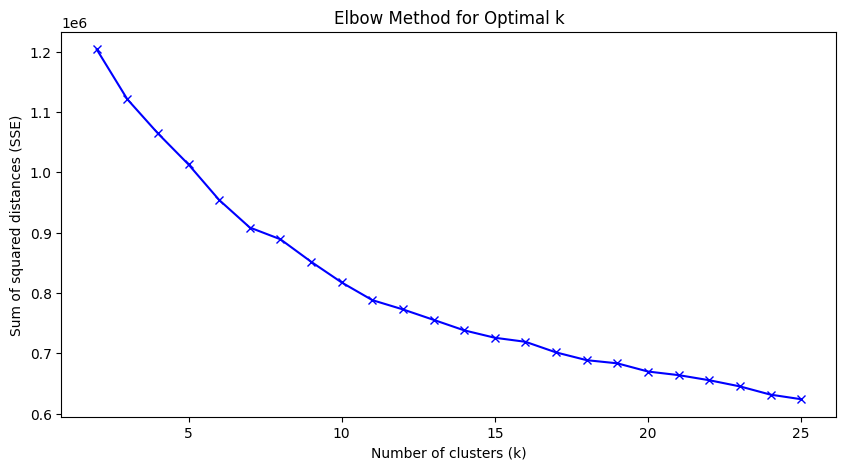

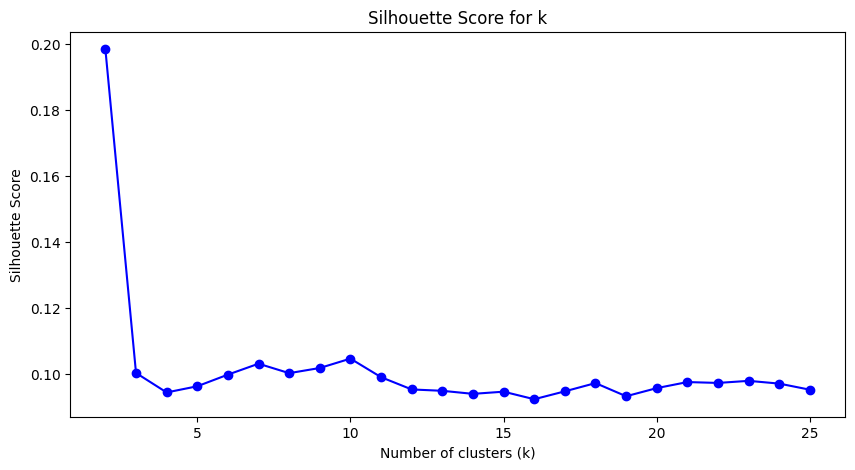

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Initialize lists to store the results
sse = []  # Sum of squared distances to the closest cluster center (inertia)
silhouette_scores = []  # Silhouette scores

# Range of k values to test
k_values = range(2, 26)

# Perform clustering for each k and calculate the SSE and silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_kmean_scaled)
    
    # Append SSE (inertia)
    sse.append(kmeans.inertia_)
    
    # Append silhouette score
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_kmean_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(k_values, sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for k')
plt.show()


In [29]:

# Step 2: Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
df_kmean['cluster_kmean'] = kmeans.fit_predict(df_kmean_scaled)

# Step 3: Check the resulting clusters
print(df_kmean[['artists', 'track_name', 'track_genre', 'cluster_kmean']].head(10))

                  artists                  track_name        track_genre  \
0             Gen Hoshino                      Comedy           acoustic   
1             Gen Hoshino                      Comedy              j-pop   
2             Gen Hoshino                      Comedy  singer-songwriter   
3             Gen Hoshino                      Comedy         songwriter   
4            Ben Woodward            Ghost - Acoustic           acoustic   
5            Ben Woodward            Ghost - Acoustic              chill   
6  Ingrid Michaelson;ZAYN              To Begin Again           acoustic   
7            Kina Grannis  Can't Help Falling In Love           acoustic   
8        Chord Overstreet                     Hold On           acoustic   
9            Tyrone Wells        Days I Will Remember           acoustic   

   cluster_kmean  
0              6  
1              6  
2              6  
3              6  
4              1  
5              1  
6              1  
7          

In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter

# Assuming df_kmean is already defined and contains the data

# Step 1: Preprocessing

# Drop the non-numeric columns (e.g., 'artists', 'track_name', 'track_genre')
df_kmean_numeric = df_kmean.drop(columns=['artists', 'track_name', 'track_genre'])

# Standardize the features
scaler = StandardScaler()
df_kmean_scaled = scaler.fit_transform(df_kmean_numeric)

# Step 2: Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
df_kmean['cluster_kmean'] = kmeans.fit_predict(df_kmean_scaled)

# Step 3: Calculate Cluster Purity

# Initialize variables
total_points = len(df_kmean)
correct_points = 0

# Iterate through each cluster to calculate purity
for cluster in range(10):
    # Get the data points that belong to the current cluster
    cluster_data = df_kmean[df_kmean['cluster_kmean'] == cluster]
    
    # Find the most common genre in the cluster
    most_common_genre = Counter(cluster_data['track_genre']).most_common(1)[0][0]
    
    # Count how many points in the cluster match the most common genre
    correct_points += sum(cluster_data['track_genre'] == most_common_genre)

# Calculate overall purity
purity = correct_points / total_points

print(f"Overall Cluster Purity: {purity:.4f}")

# Optional: Display purity per cluster
for cluster in range(10):
    cluster_data = df_kmean[df_kmean['cluster_kmean'] == cluster]
    most_common_genre = Counter(cluster_data['track_genre']).most_common(1)[0][0]
    cluster_purity = sum(cluster_data['track_genre'] == most_common_genre) / len(cluster_data)
    print(f"Cluster {cluster} Purity: {cluster_purity:.4f}")


Overall Cluster Purity: 0.0513
Cluster 0 Purity: 0.0508
Cluster 1 Purity: 0.0484
Cluster 2 Purity: 0.7595
Cluster 3 Purity: 0.0817
Cluster 4 Purity: 0.0395
Cluster 5 Purity: 0.0741
Cluster 6 Purity: 0.1169
Cluster 7 Purity: 0.0234
Cluster 8 Purity: 0.0209
Cluster 9 Purity: 0.0194


The clustering results show:

- **Overall Purity (0.0513):** Low, indicating poor clustering performance.
- **Cluster 2 Purity (0.7595):** Significantly higher, suggesting this cluster is well-defined.
- **Other Clusters:** Mostly low purity, with Clusters 7, 8, and 9 particularly poor (below 0.025), indicating substantial class mixing and poor cluster separation.
  
**Key Takeaway:** Only Cluster 2 is well-defined, while the rest show poor clustering, suggesting the need for improvements in the clustering approach.

As we're having this poor distribution I decide to switch to soft clustering with GMM that might be more relevant for the work we are doing on trying to classify genre. 

# Soft Clustering 

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# Step 1: Preprocessing
# Assuming df_kmean is your DataFrame

# Drop the non-numeric columns (e.g., 'artists', 'track_name', 'track_genre')
df_gmm_numeric = df_kmean.drop(columns=['artists', 'track_name', 'track_genre'])

# Standardize the features
scaler = StandardScaler()
df_gmm_scaled = scaler.fit_transform(df_gmm_numeric)

# Step 2: Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)
df_kmean['cluster_gmm'] = gmm.fit_predict(df_gmm_scaled)

# Obtain the soft clustering probabilities
df_kmean['cluster_probabilities'] = gmm.predict_proba(df_gmm_scaled).tolist()

# Step 3: Evaluate Clustering Performance
print(f"Log Likelihood: {gmm.score(df_gmm_scaled)}")
print(f"BIC: {gmm.bic(df_gmm_scaled)}")

# Display the first few rows with cluster assignments and probabilities
df_kmean[['artists', 'track_name', 'track_genre', 'cluster_gmm', 'cluster_probabilities']].head(10)

Log Likelihood: -6.121891304252306
BIC: 1242586.1144685384


,artists,track_name,track_genre,cluster_gmm,cluster_probabilities
0,Gen Hoshino,Comedy,acoustic,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 3.6145349170552285e-..."
1,Gen Hoshino,Comedy,j-pop,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 3.6145349170552285e-..."
2,Gen Hoshino,Comedy,singer-songwriter,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 3.6145349170552285e-..."
3,Gen Hoshino,Comedy,songwriter,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 3.6145349170552285e-..."
4,Ben Woodward,Ghost - Acoustic,acoustic,4,"[0.0, 0.0, 0.0, 0.0, 0.9999999959159265, 4.084..."
5,Ben Woodward,Ghost - Acoustic,chill,4,"[0.0, 0.0, 0.0, 0.0, 0.9999999959159265, 4.084..."
6,Ingrid Michaelson;ZAYN,To Begin Again,acoustic,4,"[0.0, 0.0, 0.0, 0.0, 0.9999999978975596, 2.102..."
7,Kina Grannis,Can't Help Falling In Love,acoustic,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 2.2888209129523e-31,..."
8,Chord Overstreet,Hold On,acoustic,4,"[0.0, 0.0, 0.0, 0.0, 0.9999999999586544, 4.134..."
9,Tyrone Wells,Days I Will Remember,acoustic,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0146713558186038e-..."


Number of Clusters: 2
Log Likelihood: -1263522.4546053596
BIC: 2530165.477810672
----------------------------------------
Number of Clusters: 3
Log Likelihood: -679971.5996502285
BIC: 1364629.809707028
----------------------------------------
Number of Clusters: 4
Log Likelihood: -829813.6047668814
BIC: 1665879.8617469524
----------------------------------------
Number of Clusters: 5
Log Likelihood: -680923.9269848929
BIC: 1369666.5479895938
----------------------------------------
Number of Clusters: 6
Log Likelihood: -751843.854842857
BIC: 1513072.4455121402
----------------------------------------
Number of Clusters: 7
Log Likelihood: -714177.7927253052
BIC: 1439306.363083655
----------------------------------------
Number of Clusters: 8
Log Likelihood: -774494.1068192077
BIC: 1561505.0330780784
----------------------------------------
Number of Clusters: 9
Log Likelihood: -675152.3327819913
BIC: 1364387.526810264
----------------------------------------
Number of Clusters: 10
Log L

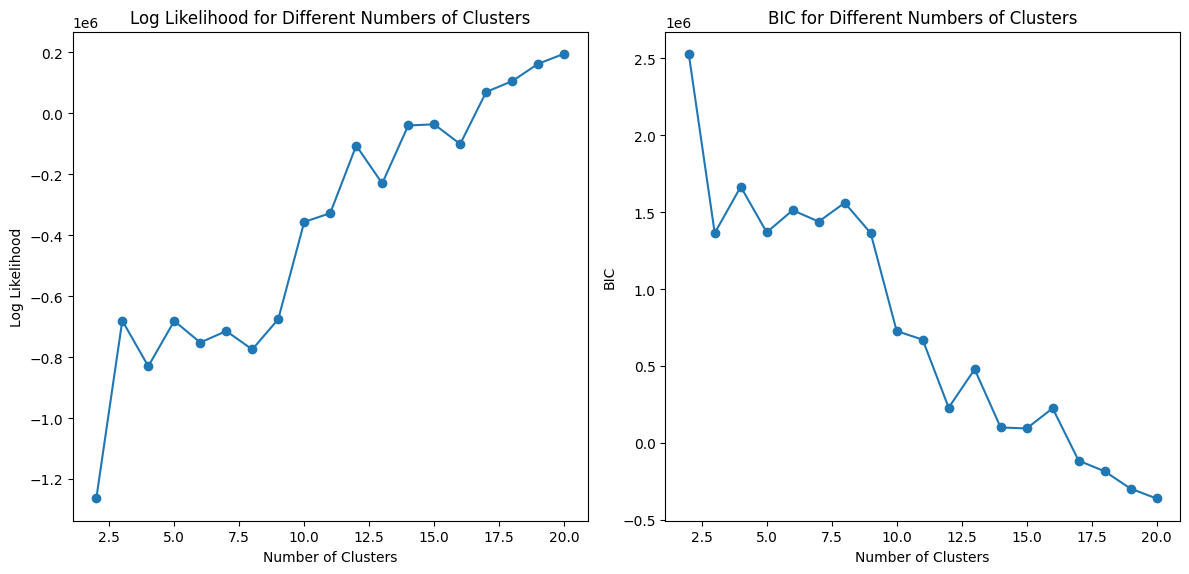

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Assuming df_kmean_numeric contains the numeric data after preprocessing

# Step 1: Standardize the features
scaler = StandardScaler()
df_kmean_scaled = scaler.fit_transform(df_kmean_numeric)

# Step 2: Loop over different numbers of clusters (4 to 20)
log_likelihoods = []
bics = []
n_clusters_range = range(2, 21)

for n_clusters in n_clusters_range:
    # Fit GMM model
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(df_kmean_scaled)
    
    # Calculate Log Likelihood and BIC
    log_likelihood = gmm.score(df_kmean_scaled) * len(df_kmean_scaled)
    bic = gmm.bic(df_kmean_scaled)
    
    # Append results to lists
    log_likelihoods.append(log_likelihood)
    bics.append(bic)
    
    print(f"Number of Clusters: {n_clusters}")
    print(f"Log Likelihood: {log_likelihood}")
    print(f"BIC: {bic}")
    print("-" * 40)

# Step 3: Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, log_likelihoods, marker='o')
plt.title('Log Likelihood for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Log Likelihood')

plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, bics, marker='o')
plt.title('BIC for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')

plt.tight_layout()
plt.show()


The results indicate the following:
    
    Clusters 2 to 10: Generally, BIC values are high, with decreasing log likelihoods, suggesting that these models do not fit the data well.

    Clusters 11 to 15: BIC values decrease significantly, indicating an improvement in model fit.

    Clusters 16 to 20: The BIC becomes negative, and log likelihoods increase, showing a substantial improvement in model fit, especially from Cluster 17 onwards.

Key Takeaway: Models with 17 to 20 clusters show much better fit, as indicated by positive log likelihoods and negative BICs, suggesting these clusters better capture the data structure.

### Assigning Cluster Label

In [33]:
from sklearn.mixture import GaussianMixture
import pandas as pd

# Assuming df_kmean_scaled is your standardized dataset from the previous step
# and df_kmean is your original dataset

# Fit the GMM model with 17 clusters
gmm = GaussianMixture(n_components=17, random_state=42)
gmm.fit(df_kmean_scaled)

# Predict cluster labels for each data point
df_kmean['cluster_label'] = gmm.predict(df_kmean_scaled)

# Optional: Add probabilities for each cluster (soft assignments)
df_kmean[['cluster_prob_' + str(i) for i in range(17)]] = gmm.predict_proba(df_kmean_scaled)

# Display the first few rows with cluster labels
print(df_kmean.head())

        artists        track_name  popularity  duration_ms  danceability  \
0   Gen Hoshino            Comedy          73       230666         0.676   
1   Gen Hoshino            Comedy          73       230666         0.676   
2   Gen Hoshino            Comedy          73       230666         0.676   
3   Gen Hoshino            Comedy          73       230666         0.676   
4  Ben Woodward  Ghost - Acoustic          55       149610         0.420   

   energy  key  loudness  mode  speechiness  ...  cluster_prob_7  \
0   0.461    1    -6.746     0       0.1430  ...    1.269129e-08   
1   0.461    1    -6.746     0       0.1430  ...    1.269129e-08   
2   0.461    1    -6.746     0       0.1430  ...    1.269129e-08   
3   0.461    1    -6.746     0       0.1430  ...    1.269129e-08   
4   0.166    1   -17.235     1       0.0763  ...    0.000000e+00   

   cluster_prob_8  cluster_prob_9  cluster_prob_10  cluster_prob_11  \
0             0.0        0.000000              0.0             

In [47]:
df_soft = df_kmean.copy()
df_soft['cluster_label']

0         13
1         13
2         13
3         13
4          4
          ..
100204     6
100205     6
100206     4
100207     4
100208     4
Name: cluster_label, Length: 100209, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Prepare the data

# Features to use for the model (all numerical features excluding the target and original non-numeric columns)
features = df_soft.drop(columns=['artists', 'track_name', 'track_genre', 'cluster_label',
                                 'cluster_probabilities', 'cluster_gmm'] +
                                [f'cluster_prob_{i}' for i in range(17)])

# Target variable
target = df_soft['cluster_label']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Train the Classification Model
# Here, we'll use a Random Forest as an example
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = rf_model.predict(X_test)

# Print model evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9886238898313542
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       796
           1       0.99      0.99      0.99       940
           2       0.97      0.98      0.97       986
           3       0.98      0.99      0.98      1905
           4       1.00      1.00      1.00      2249
           5       0.99      0.91      0.95       466
           6       0.98      1.00      0.99       915
           7       0.98      0.87      0.92        62
           8       0.99      1.00      0.99      2529
           9       0.98      0.99      0.99       866
          10       1.00      1.00      1.00      2333
          11       0.99      0.99      0.99      1170
          12       1.00      0.99      0.99       208
          13       0.99      1.00      0.99      3936
          14       1.00      0.30      0.46        10
          15       0.98      0.83      0.90       237
          16       0.97     

## Cluster Interpretation

In [57]:
import pandas as pd

# Group by cluster and genre, and count the number of occurrences
genre_distribution = df_soft.groupby(['cluster_label', 'track_genre']).size().reset_index(name='count')

# Pivot the table to see clusters as rows and genres as columns
genre_distribution_pivot = genre_distribution.pivot(index='cluster_label', columns='track_genre', values='count').fillna(0)

genre_distribution_pivot.to_csv('genre_distribution_clusters.csv')

# Display the genre distribution table
print(genre_distribution_pivot)

track_genre    acoustic  afrobeat  alt-rock  alternative  ambient  anime  \
cluster_label                                                              
0                  12.0      67.0      36.0         28.0      6.0   19.0   
1                  92.0      20.0      16.0         18.0     96.0   19.0   
2                  17.0      70.0      60.0         44.0      1.0   31.0   
3                   2.0     206.0      29.0         17.0     79.0   95.0   
4                 425.0      36.0      47.0         47.0     51.0   12.0   
5                   4.0      10.0       8.0          7.0     30.0   26.0   
6                  25.0       4.0       2.0          1.0    531.0  115.0   
7                   2.0       7.0       2.0          4.0      0.0    0.0   
8                 124.0      82.0     148.0        126.0     15.0  140.0   
9                  62.0      36.0      17.0         16.0     78.0   40.0   
10                102.0      65.0     125.0        104.0     17.0  119.0   
11          

In [62]:
# Calculate summary statistics for each feature by cluster
cluster_feature_stats = df_soft.groupby('cluster_label').agg({
    'popularity': ['mean', 'median', 'std'],
    'duration_ms': ['mean', 'median', 'std'],
    'danceability': ['mean', 'median', 'std'],
    'energy': ['mean', 'median', 'std'],
    'key': ['mean', 'median', 'std'],
    'loudness': ['mean', 'median', 'std'],
    'mode': ['mean', 'median', 'std'],
    'speechiness': ['mean', 'median', 'std'],
    'acousticness': ['mean', 'median', 'std'],
    'instrumentalness': ['mean', 'median', 'std'],
    'liveness': ['mean', 'median', 'std'],
    'valence': ['mean', 'median', 'std'],
    'tempo': ['mean', 'median', 'std'],
    'time_signature': ['mean', 'median', 'std']
}).reset_index()

cluster_feature_stats.to_csv('cluster_feature_statistics.csv', index=False)

# Display the feature statistics for each cluster
print(cluster_feature_stats)

   cluster_label popularity                     duration_ms             \
                       mean median        std          mean     median   
0              0  34.560904   33.0  20.614167  2.320242e+05   223211.5   
1              1  32.632974   33.0  21.246751  2.115645e+05   206059.5   
2              2  35.629957   34.0  21.313384  2.276396e+05   217226.5   
3              3  27.144596   22.0  17.939673  2.949904e+05   281983.0   
4              4  37.640401   40.0  20.220052  2.177311e+05   211851.0   
5              5  28.705906   26.0  18.565349  2.492814e+05   208967.0   
6              6  30.502578   27.0  20.873342  2.106146e+05   187733.0   
7              7  36.409222   37.0  19.943119  2.285615e+05   224983.0   
8              8  37.946173   39.0  21.319970  2.181002e+05   211600.0   
9              9  37.080362   39.0  20.301289  1.981961e+05   189073.0   
10            10  38.190041   39.0  21.310876  2.172561e+05   210333.0   
11            11  36.698976   40.0  15

In [70]:
import pandas as pd

# Load the cluster feature statistics
cluster_features = pd.read_csv('cluster_feature_statistics.csv')

# Display the feature statistics for each cluster
cluster_features.to_csv('yooooooooo.csv', index=False)


In [69]:
# Load the genre distribution per cluster
genre_distribution = pd.read_csv('genre_distribution_clusters.csv')

# Display the genre distribution for each cluster
print(genre_distribution)



    cluster_label  acoustic  afrobeat  alt-rock  alternative  ambient  anime  \
0               0      12.0      67.0      36.0         28.0      6.0   19.0   
1               1      92.0      20.0      16.0         18.0     96.0   19.0   
2               2      17.0      70.0      60.0         44.0      1.0   31.0   
3               3       2.0     206.0      29.0         17.0     79.0   95.0   
4               4     425.0      36.0      47.0         47.0     51.0   12.0   
5               5       4.0      10.0       8.0          7.0     30.0   26.0   
6               6      25.0       4.0       2.0          1.0    531.0  115.0   
7               7       2.0       7.0       2.0          4.0      0.0    0.0   
8               8     124.0      82.0     148.0        126.0     15.0  140.0   
9               9      62.0      36.0      17.0         16.0     78.0   40.0   
10             10     102.0      65.0     125.0        104.0     17.0  119.0   
11             11      12.0      45.0   

In [73]:
import pandas as pd

# Check if 'track_genre' and 'cluster_gmm' columns are present
if 'track_genre' not in df_soft.columns or 'cluster_label' not in df_soft.columns:
    raise ValueError("The dataset must contain 'track_genre' and 'cluster_label' columns")

# Group by 'cluster_gmm' and count the occurrences of each genre within each cluster
genre_distribution = df_soft.groupby(['cluster_label', 'track_genre']).size().reset_index(name='count')

# Sort the genres by count within each cluster and select the top 15
top_15_genres_per_cluster = genre_distribution.groupby('cluster_label').apply(lambda x: x.nlargest(15, 'count')).reset_index(drop=True)

# Display the top 15 prevalent genres for each cluster
print(top_15_genres_per_cluster)

# Save the top 15 prevalent genres per cluster to a CSV file
top_15_genres_per_cluster.to_csv('top_15_genres_per_cluster.csv', index=False)


     cluster_label  track_genre  count
0                0  death-metal    121
1                0   industrial     98
2                0    breakbeat     89
3                0         club     86
4                0    synth-pop     86
..             ...          ...    ...
250             16       german     43
251             16        malay     43
252             16      spanish     43
253             16          sad     42
254             16        anime     41

[255 rows x 3 columns]


/var/folders/np/6f_bnw1d3wb20pq5fckz0_c40000gn/T/ipykernel_56669/3754183593.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_15_genres_per_cluster = genre_distribution.groupby('cluster_label').apply(lambda x: x.nlargest(15, 'count')).reset_index(drop=True)



## Cluster Descriptions

### Cluster 0:
- **Musical Composition:**
  This cluster has a strong presence of high-energy, rhythm-driven music, with a significant focus on electronic and dance genres. There's a noticeable inclination towards breakbeats, drum-and-bass, and deep house, which are characterized by fast-paced rhythms and heavy basslines.
  
- **Genres:**
  - **Dominant Genres:** Drum-and-bass, deep house, breakbeat, British electronic music.
  - **Other Notable Genres:** Alternative, electro, EDM, house, techno.

### Cluster 1:
- **Musical Composition:**
  Cluster 1 is characterized by a blend of ambient, alternative, and British music, creating a mix of mellow, atmospheric sounds with an indie feel. This cluster leans towards more introspective and ambient music, often featuring a combination of electronic and acoustic elements.
  
- **Genres:**
  - **Dominant Genres:** Ambient, alternative, British, indie pop.
  - **Other Notable Genres:** Chill, folk, classical, indie.

### Cluster 2:
- **Musical Composition:**
  This cluster is defined by its heavy emphasis on metal genres, including black metal, death metal, and metalcore. The music here is intense, with aggressive guitar riffs, fast drumming, and powerful vocals. There is also a presence of electronic genres, adding a unique contrast to the overall heavy sound.
  
- **Genres:**
  - **Dominant Genres:** Black metal, death metal, metalcore, grindcore.
  - **Other Notable Genres:** Dubstep, electro, industrial, hardcore.

### Cluster 3:
- **Musical Composition:**
  Cluster 3 is the most extreme in terms of musical intensity. It features a heavy concentration of the most aggressive metal subgenres like grindcore and death metal, along with elements of hardcore punk. The music in this cluster is characterized by its speed, aggression, and often dark thematic content.
  
- **Genres:**
  - **Dominant Genres:** Black metal, grindcore, death metal, hardcore punk.
  - **Other Notable Genres:** Industrial, metalcore, dark ambient.

### Cluster 4:
- **Musical Composition:**
  This cluster has a diverse mix, with a strong representation of genres rooted in different cultural backgrounds. There's a significant influence from Brazilian music (e.g., samba, pagode), as well as funk, disco, and dance-oriented genres. The music here is often vibrant, rhythmic, and upbeat.
  
- **Genres:**
  - **Dominant Genres:** Samba, pagode, funk, disco.
  - **Other Notable Genres:** Brazilian, house, electronic, pop.

### Cluster 5:
- **Musical Composition:**
  Cluster 5 leans towards softer, more melodic music with an emphasis on acoustic, folk, and country genres. The music here is generally mellow and often features acoustic instruments, emphasizing lyrical content and storytelling.
  
- **Genres:**
  - **Dominant Genres:** Acoustic, folk, country, singer-songwriter.
  - **Other Notable Genres:** Blues, bluegrass, indie folk.

### Cluster 6:
- **Musical Composition:**
  This cluster is dominated by ambient and minimalistic genres, focusing on spacey, often instrumental soundscapes. The music is generally calm, with a focus on creating atmospheric or meditative moods.
  
- **Genres:**
  - **Dominant Genres:** Ambient, minimal techno, new-age, drone.
  - **Other Notable Genres:** Classical, electronic, experimental.

### Cluster 7:
- **Musical Composition:**
  Cluster 7 is characterized by its representation of niche genres, often associated with specific cultural or regional styles. The music here is diverse but tends to be less mainstream, focusing on specialized sounds.
  
- **Genres:**
  - **Dominant Genres:** Garage rock, punk rock, ska, reggae.
  - **Other Notable Genres:** Surf rock, psych rock, grunge.

### Cluster 8:
- **Musical Composition:**
  Cluster 8 has a strong focus on popular genres, with a mix of pop, dance, and electronic music. This cluster represents mainstream music with a high energy level, often associated with radio-friendly hits and club music.
  
- **Genres:**
  - **Dominant Genres:** Pop, dance, EDM, electro-pop.
  - **Other Notable Genres:** Synth-pop, progressive house, trance.

### Cluster 9:
- **Musical Composition:**
  This cluster leans towards more traditional and regional music styles. It includes a mix of Latin, jazz, and blues, emphasizing rhythmic and melodic complexity, often with a rich cultural heritage.
  
- **Genres:**
  - **Dominant Genres:** Latin, jazz, blues, salsa.
  - **Other Notable Genres:** Samba, tango, flamenco, bossa nova.

### Cluster 10:
- **Musical Composition:**
  Cluster 10 is characterized by an eclectic mix of both mainstream and alternative genres. It has a significant presence of rock and electronic music, with elements that range from indie and alternative to more experimental sounds.
  
- **Genres:**
  - **Dominant Genres:** Rock, alternative, indie, electro.
  - **Other Notable Genres:** Emo, post-punk, synth-pop.

### Cluster 11:
- **Musical Composition:**
  This cluster is focused on genres that are associated with specific subcultures or underground movements. It includes a mix of punk, metal, and alternative music, often with a raw and unpolished sound.
  
- **Genres:**
  - **Dominant Genres:** Punk, punk rock, grunge, hardcore.
  - **Other Notable Genres:** Post-punk, emo, garage rock.

### Cluster 12:
- **Musical Composition:**
  Cluster 12 represents the most minimalistic and ambient-oriented music, often instrumental, focusing on creating a calm and meditative atmosphere. It includes ambient, new-age, and minimalist genres.
  
- **Genres:**
  - **Dominant Genres:** Ambient, minimalism, new-age, drone.
  - **Other Notable Genres:** Experimental, post-rock, avant-garde.

### Cluster 13:
- **Musical Composition:**
  This cluster is characterized by a high concentration of genres that blend electronic and rock elements, focusing on energetic and rhythmic music with a mix of traditional and modern sounds.
  
- **Genres:**
  - **Dominant Genres:** Electro-rock, industrial, post-punk, alternative.
  - **Other Notable Genres:** Synth-pop, dark wave, new wave.

### Cluster 14:
- **Musical Composition:**
  Cluster 14 is very sparse, indicating a focus on highly niche or experimental genres. The music is likely avant-garde, with a tendency towards unconventional structures and sounds.
  
- **Genres:**
  - **Dominant Genres:** Avant-garde, experimental, noise.
  - **Other Notable Genres:** Minimalism, drone, post-industrial.

### Cluster 15:
- **Musical Composition:**
  This cluster has a focus on traditional and folk music, with a significant presence of genres associated with cultural and historical traditions. The music here is often acoustic and emphasizes storytelling and cultural heritage.
  
- **Genres:**
  - **Dominant Genres:** Folk, world music, traditional, bluegrass.
  - **Other Notable Genres:** Country, Celtic, Americana.

### Cluster 16:
- **Musical Composition:**
  Cluster 16 is characterized by its eclectic mix, including a wide range of genres from different cultural backgrounds. The music is diverse, often incorporating elements from various traditions and modern influences.
  
- **Genres:**
  - **Dominant Genres:** World music, folk, traditional, ethnic.
  - **Other Notable Genres:** Jazz, blues, Latin, African.


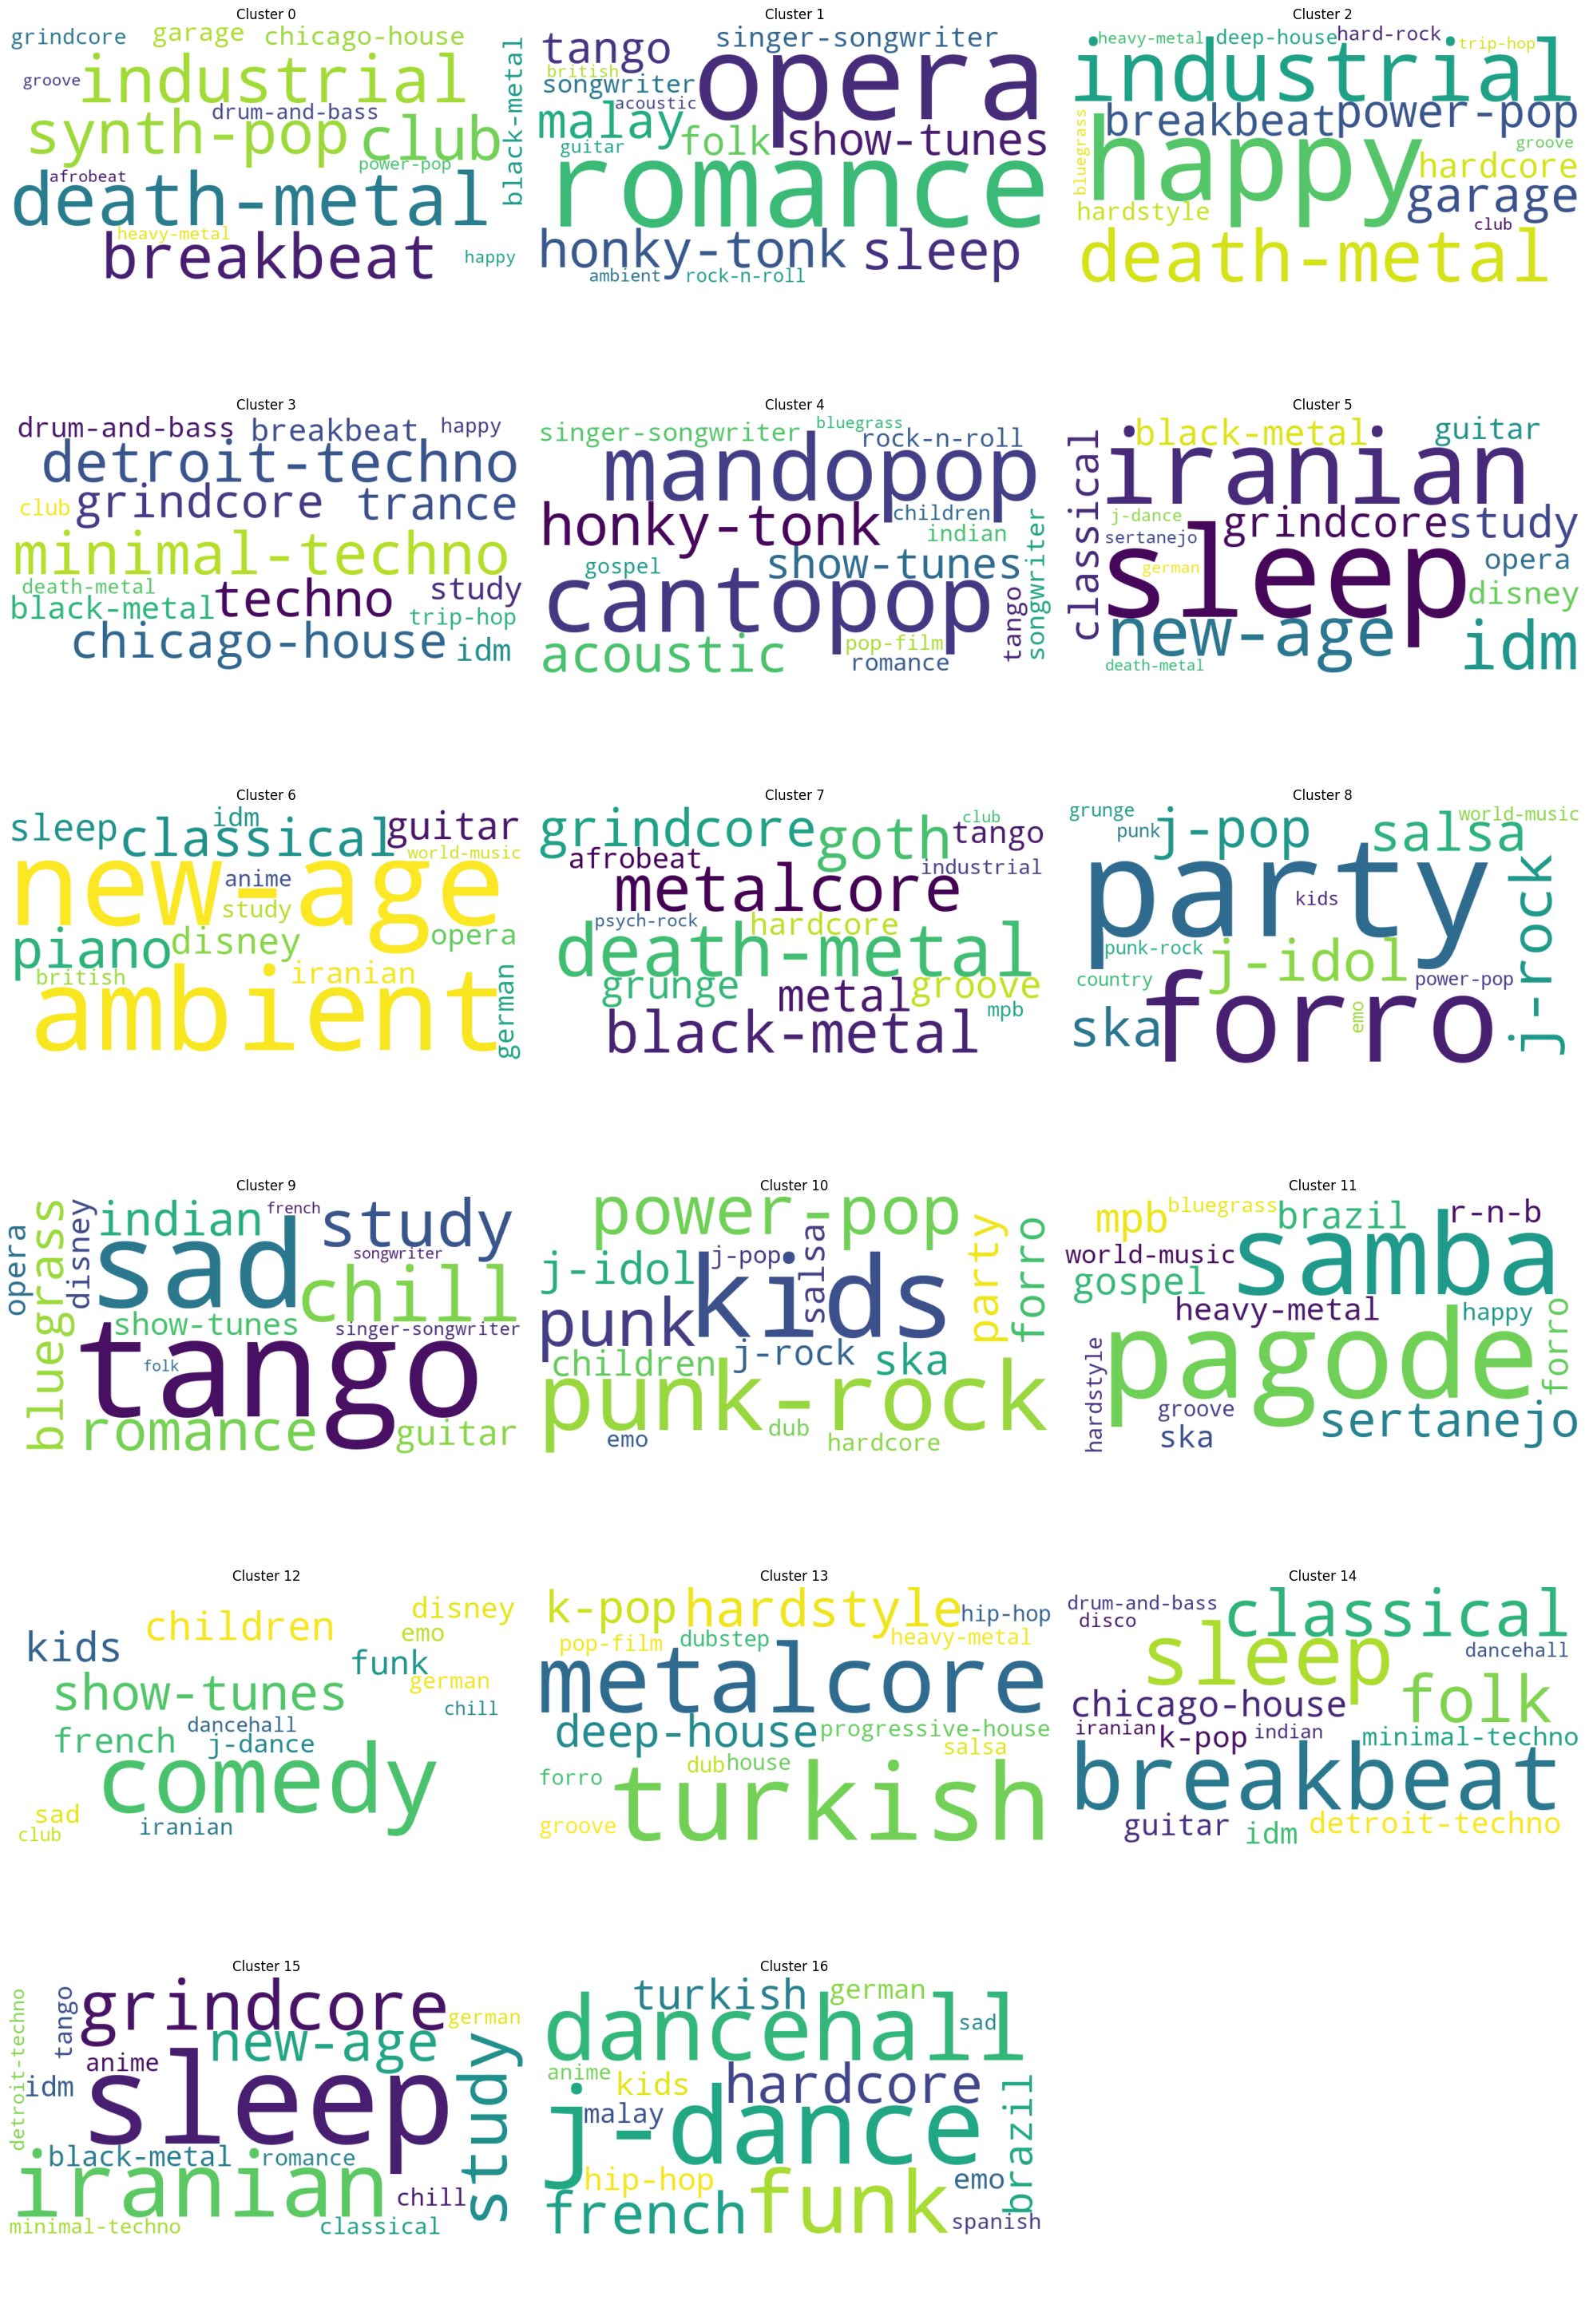

In [2]:
import pandas as pd

file_path = 'top_15_genres_per_cluster.csv'
data = pd.read_csv(file_path)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the unique cluster labels
clusters = data['cluster_label'].unique()

# Define the number of clusters per row for better visualization
clusters_per_row = 3
num_clusters = len(clusters)
num_rows = (num_clusters // clusters_per_row) + (num_clusters % clusters_per_row > 0)

# Set up the plot grid with multiple rows and columns
fig, axes = plt.subplots(nrows=num_rows, ncols=clusters_per_row, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a WordCloud for each cluster and plot it in a subplot
for idx, cluster in enumerate(clusters):
    # Filter data for the current cluster
    cluster_data = data[data['cluster_label'] == cluster]
    
    # Prepare the data for the word cloud (track_genre: count)
    genre_freq = dict(zip(cluster_data['track_genre'], cluster_data['count']))
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_freq)
    
    # Plot the word cloud in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster}')
    axes[idx].axis('off')

# Hide any unused subplots
for idx in range(len(clusters), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()




# Models 

## XGboost

In [77]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Prepare the data

# Features to use for the model (all numerical features excluding the target and original non-numeric columns)
features = df_soft.drop(columns=['artists', 'track_name', 'track_genre', 'cluster_label',
                                 'cluster_probabilities', 'cluster_gmm'] +
                                [f'cluster_prob_{i}' for i in range(17)])

# Target variable
target = df_soft['cluster_label']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Train the Classification Model using XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = xgb_model.predict(X_test)

# Print model evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9916674982536673
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       796
           1       0.99      0.99      0.99       940
           2       0.99      0.98      0.98       986
           3       0.98      0.99      0.99      1905
           4       1.00      1.00      1.00      2249
           5       0.97      0.95      0.96       466
           6       0.99      0.99      0.99       915
           7       0.94      0.97      0.95        62
           8       0.99      1.00      1.00      2529
           9       0.99      0.99      0.99       866
          10       1.00      1.00      1.00      2333
          11       0.99      0.99      0.99      1170
          12       1.00      0.99      1.00       208
          13       0.99      1.00      1.00      3936
          14       0.71      0.50      0.59        10
          15       0.96      0.91      0.94       237
          16       0.98     

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

# Step 1: Prepare the data

# Features to use for the model (all numerical features excluding the target and original non-numeric columns)
features = df_soft.drop(columns=['artists', 'track_name', 'track_genre', 'cluster_label',
                                 'cluster_probabilities', 'cluster_gmm'] +
                                [f'cluster_prob_{i}' for i in range(17)])

# Target variable
target = df_soft['cluster_label']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the target labels for XGBoost (assuming the labels are starting from 1)
y_train_adjusted = y_train 
y_test_adjusted = y_test 

# Convert the datasets into DMatrix, which is the data structure that XGBoost uses
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_adjusted)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_adjusted)

# Step 3: Define the parameters grid for GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0.1, 0.3],
    'n_estimators': [100, 200]
}

# Convert training data to DMatrix for use in XGBoost API
dtrain_full = xgb.DMatrix(X_train_scaled, label=y_train_adjusted)

# Initialize an XGBClassifier for hyperparameter tuning
xgb_model = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', random_state=42)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

# Fit the model with grid search
grid_search.fit(X_train_scaled, y_train_adjusted)

# Step 4: Get the best parameters and train the model with early stopping
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")



Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Final Accuracy on Test Data: 0.9913
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       796
           1       1.00      0.99      0.99       940
           2       0.99      0.98      0.98       986
           3       0.98      0.99      0.99      1905
           4       1.00      1.00      1.00      2249
           5       0.97      0.95      0.96       466
           6       0.98      0.99      0.99       915
           7       0.92      0.95      0.94        62
           8       0.99      1.00      1.00      2529
           9       0.99      1.00      0.99       866
          10       1.00      1.00      1.00      2333
          11       0.99      0.99      0.99      1170
          12       1.00      0.99      1.00       208
          13       0.99      1.00      1.00      3936
          14       0.75      0.30      0.43        10
          15       0.94      0.90      0.92       237
          16       0.97      0.97      0.97  

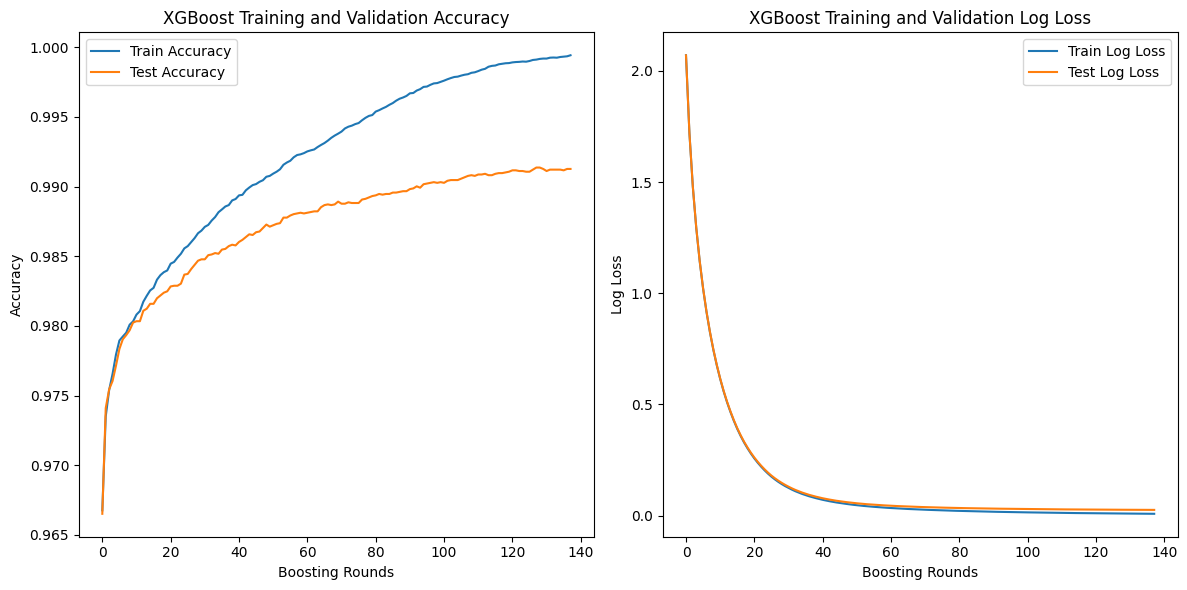

In [80]:
params = {
    'objective': 'multi:softmax',
    'eval_metric': ['mlogloss', 'merror'],  # Include both log loss and error rate
    'num_class': len(target.unique()),  # Number of unique classes
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'gamma': 0.1,
    'n_estimators': 200,
    'random_state': 42
}

# Number of boosting rounds
num_boost_round = 200

# Optionally, set up evaluation sets to track model performance
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}  # This dictionary will store the evaluation results

# Train the model with early stopping to prevent overfitting
bst = xgb.train(
    params, 
    dtrain, 
    num_boost_round, 
    evals=evals, 
    early_stopping_rounds=10, 
    evals_result=evals_result, 
    verbose_eval=False
)

# Make predictions on the test set
y_pred = bst.predict(dtest)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy on Test Data: {accuracy:.4f}")

# Optionally, print classification report
print(classification_report(y_test, y_pred))

# Extract metrics for plotting
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(epochs)

# Calculate accuracy from error
train_accuracy = [1 - x for x in evals_result['train']['merror']]
eval_accuracy = [1 - x for x in evals_result['eval']['merror']]

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_axis, train_accuracy, label='Train Accuracy')
plt.plot(x_axis, eval_accuracy, label='Test Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('XGBoost Training and Validation Accuracy')
plt.legend()

# Plot log loss
plt.subplot(1, 2, 2)
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train Log Loss')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Test Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Training and Validation Log Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Neural Networks

Epoch 1/50


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - accuracy: 0.6699 - loss: 1.0824 - val_accuracy: 0.8886 - val_loss: 0.3042
Epoch 2/50
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step - accuracy: 0.8619 - loss: 0.4011 - val_accuracy: 0.9106 - val_loss: 0.2451
Epoch 3/50
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.8920 - loss: 0.3245 - val_accuracy: 0.9227 - val_loss: 0.2136
Epoch 4/50
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - accuracy: 0.9053 - loss: 0.2801 - val_accuracy: 0.9366 - val_loss: 0.1838
Epoch 5/50
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step - accuracy: 0.9137 - loss: 0.2566 - val_accuracy: 0.9361 - val_loss: 0.1724
Epoch 6/50
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - accuracy: 0.9217 - loss: 0.2321 - val_accuracy: 0.9430 - val_loss: 0.1666
Epoch 7/50
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - accuracy: 0.9289 - loss: 0.2183 - val_accuracy: 0.9479 - val_loss: 0.1431
Epoch 8/50
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - accuracy: 0.9315 - loss: 0.21

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

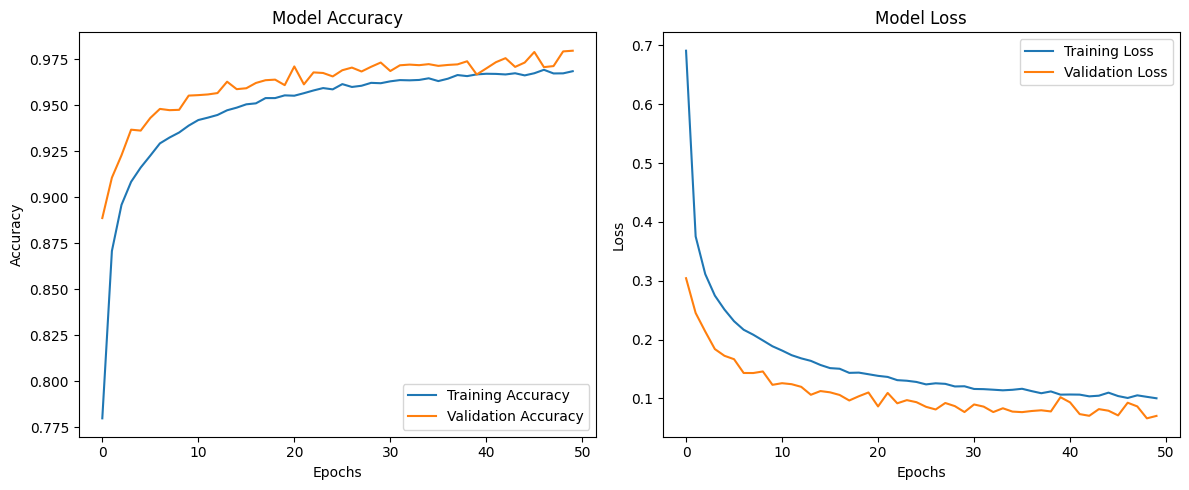

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Step 1: Prepare the data

# Features to use for the model (all numerical features excluding the target and original non-numeric columns)
features = df_soft.drop(columns=['artists', 'track_name', 'track_genre', 'cluster_label',
                                 'cluster_probabilities', 'cluster_gmm'] +
                                [f'cluster_prob_{i}' for i in range(17)])

# Target variable
target = df_soft['cluster_label']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train - 1)  # Adjusting to zero-based indexing
y_test_categorical = to_categorical(y_test - 1)    # Adjusting to zero-based indexing

# Step 3: Define the neural network architecture
model = Sequential()

# Input layer
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout to reduce overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(X_train_scaled, y_train_categorical, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Step 6: Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions and classification report
y_pred_categorical = model.predict(X_test_scaled)
y_pred = y_pred_categorical.argmax(axis=1) + 1  # Adjusting back to original label indexing

print(classification_report(y_test, y_pred))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/150


/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2005/2005 ━━━━━━━━━━━━━━━━━━━━ 2s 834us/step - accuracy: 0.5075 - loss: 1.5544 - val_accuracy: 0.8175 - val_loss: 0.4647
Epoch 2/150
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.7935 - loss: 0.5998 - val_accuracy: 0.8502 - val_loss: 0.3899
Epoch 3/150
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 2s 788us/step - accuracy: 0.8218 - loss: 0.5138 - val_accuracy: 0.8605 - val_loss: 0.3448
Epoch 4/150
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - accuracy: 0.8399 - loss: 0.4729 - val_accuracy: 0.8742 - val_loss: 0.3221
Epoch 5/150
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 2s 803us/step - accuracy: 0.8542 - loss: 0.4359 - val_accuracy: 0.8869 - val_loss: 0.2861
Epoch 6/150
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step - accuracy: 0.8685 - loss: 0.4073 - val_accuracy: 0.9046 - val_loss: 0.2727
Epoch 7/150
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 2s 799us/step - accuracy: 0.8761 - loss: 0.3813 - val_accuracy: 0.9133 - val_loss: 0.2478
Epoch 8/150
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 2s 810us/step - accuracy: 0.8889 - los

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

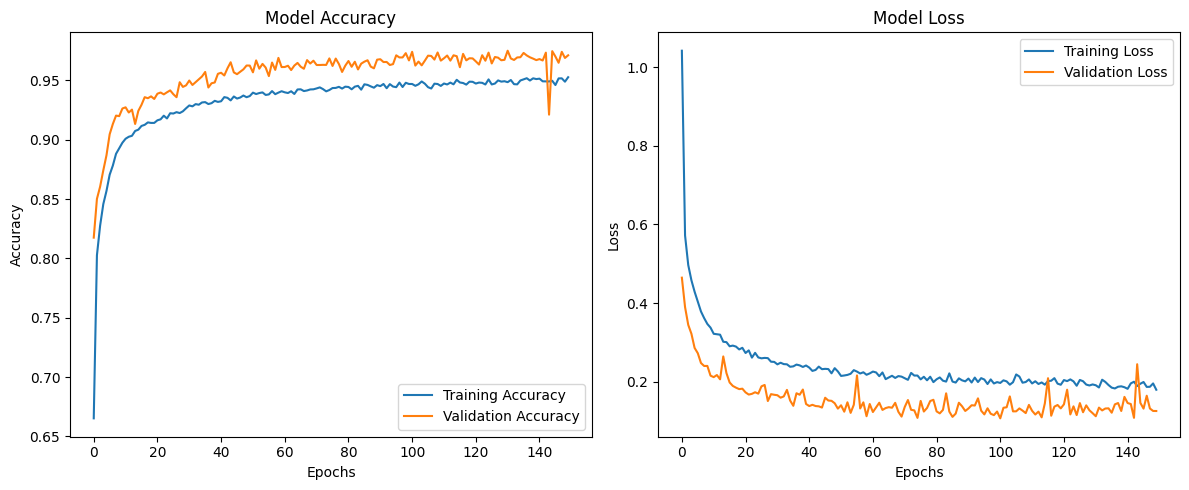

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Step 1: Prepare the data

# Features to use for the model (all numerical features excluding the target and original non-numeric columns)
features = df_soft.drop(columns=['artists', 'track_name', 'track_genre', 'cluster_label',
                                 'cluster_probabilities', 'cluster_gmm'] +
                                [f'cluster_prob_{i}' for i in range(17)])

# Target variable
target = df_soft['cluster_label']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train - 1)  # Adjusting to zero-based indexing
y_test_categorical = to_categorical(y_test - 1)    # Adjusting to zero-based indexing

# Step 3: Define the neural network architecture with additional layers
model = Sequential()

# Input layer
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout to reduce overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  # Additional layer
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))  # Additional layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model with 150 epochs
history = model.fit(X_train_scaled, y_train_categorical, epochs=150, batch_size=32, validation_split=0.2, verbose=1)

# Step 6: Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions and classification report
y_pred_categorical = model.predict(X_test_scaled)
y_pred = y_pred_categorical.argmax(axis=1) + 1  # Adjusting back to original label indexing

print(classification_report(y_test, y_pred))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


The neural network training plots indicate that the model achieved good learning and generalization, with both training and validation accuracy stabilizing around 0.9. The slightly higher validation accuracy compared to training suggests effective regularization or mild underfitting. The loss curves show a sharp decline initially, stabilizing after about 50 epochs, which reflects consistent learning. The fluctuations in validation loss suggest some variability in the model's performance across different validation batches. Overall, the model demonstrates strong performance, but further improvements could be explored through hyperparameter tuning, adjusting the architecture, or employing ensemble methods to enhance predictive accuracy and robustness.

# Ensemble methods 

/Users/victorregly/Documents/ADA/Projet Data Science/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2506/2506 ━━━━━━━━━━━━━━━━━━━━ 1s 229us/step
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step
Stacked Model Accuracy: 0.9926
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       796
           1       1.00      0.99      1.00       940
           2       0.99      0.99      0.99       986
           3       0.99      0.99      0.99      1905
           4       1.00      1.00      1.00      2249
           5       0.97      0.95      0.96       466
           6       0.99      0.99      0.99       915
           7       1.00      0.92      0.96        62
           8       0.99      1.00      1.00      2529
           9       0.99      0.99      0.99       866
          10       1.00      1.00      1.00      2333
          11       0.99      0.99      0.99      1170
          12       1.00      0.99      1.00       208
          13       0.99      1.00      1.00      3936
          14       1.00      0.40      0.57   

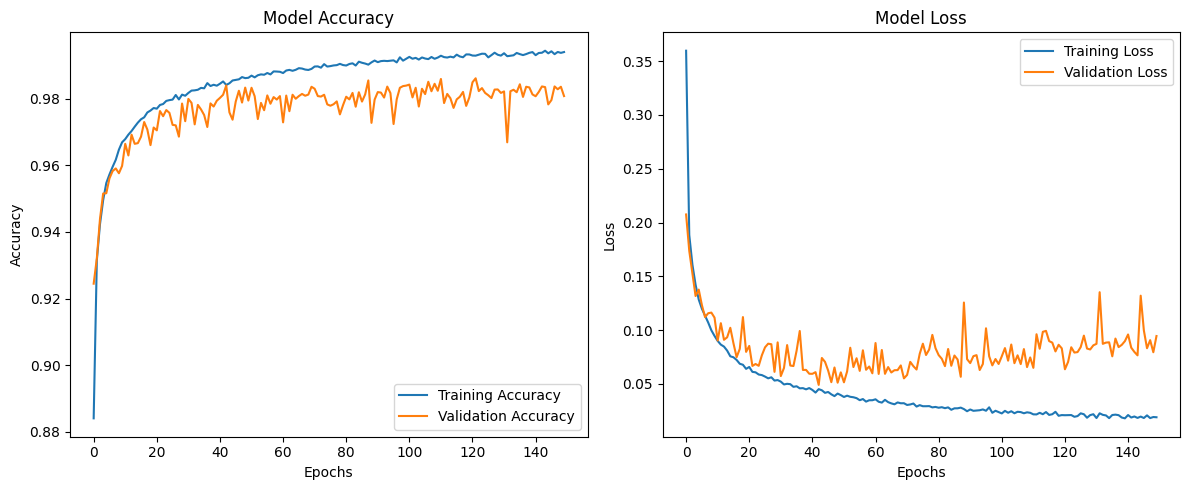

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import tensorflow as tf
from sklearn.ensemble import StackingClassifier
import numpy as np

# Step 1: Prepare the data
features = df_soft.drop(columns=['artists', 'track_name', 'track_genre', 'cluster_label',
                                 'cluster_probabilities', 'cluster_gmm'] +
                                [f'cluster_prob_{i}' for i in range(17)])
target = df_soft['cluster_label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define the Neural Network separately
def create_nn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(len(y_train.unique()), activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train the Neural Network model
nn_model = create_nn_model()
history = nn_model.fit(X_train_scaled, y_train, epochs=150, batch_size=32, verbose=0, validation_data=(X_test_scaled, y_test))

# Predict with Neural Network for stacking
y_pred_nn_train = nn_model.predict(X_train_scaled)
y_pred_nn_test = nn_model.predict(X_test_scaled)

# Step 3: Train other base models (XGBoost and RandomForest)
xgb_model = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', learning_rate=0.1,
                              max_depth=5, subsample=0.8, colsample_bytree=1.0, gamma=0.1, n_estimators=200,
                              random_state=42)
xgb_model.fit(X_train_scaled, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict with XGBoost and RandomForest for stacking
y_pred_xgb_train = xgb_model.predict_proba(X_train_scaled)
y_pred_rf_train = rf_model.predict_proba(X_train_scaled)

y_pred_xgb_test = xgb_model.predict_proba(X_test_scaled)
y_pred_rf_test = rf_model.predict_proba(X_test_scaled)

# Combine predictions for stacking
stacked_train_features = np.hstack((y_pred_nn_train, y_pred_xgb_train, y_pred_rf_train))
stacked_test_features = np.hstack((y_pred_nn_test, y_pred_xgb_test, y_pred_rf_test))

# Step 4: Meta-Model for Stacking (Logistic Regression)
meta_model = LogisticRegression(random_state=42)
meta_model.fit(stacked_train_features, y_train)

# Step 5: Evaluate the Stacked Model
y_pred_stacked = meta_model.predict(stacked_test_features)
accuracy = accuracy_score(y_test, y_pred_stacked)
print(f"Stacked Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_stacked))

# Optionally: Plot accuracy and loss curves for the Neural Network
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### Analysis of the Stacked Ensemble Model Performance

The stacked ensemble model, which combines the predictions from a neural network, XGBoost, and Random Forest, achieved an impressive accuracy of **99.26%** on the test data. The classification report also shows high precision, recall, and F1-scores across most clusters, indicating that the model performs exceptionally well in distinguishing between different clusters.

#### Key Observations:

1. **High Overall Accuracy**: The accuracy of 99.26% suggests that the ensemble model is highly effective at predicting the correct cluster for a given track based on its features. This high performance can be attributed to the diversity and complementary strengths of the individual models used in the ensemble.

2. **Consistency Across Clusters**: Most clusters show near-perfect precision and recall, indicating that the model consistently identifies tracks in those clusters correctly. Clusters 1, 2, 3, 4, 8, 10, and 13 have particularly high performance metrics, reflecting strong model confidence and correct predictions for these groups.

3. **Clusters with Lower Performance**: A few clusters, such as Cluster 5 and Cluster 15, have slightly lower performance metrics (precision and recall around 0.95). This could be due to the characteristics of these clusters, such as overlap with other clusters or more diverse musical features, making them harder to distinguish.

4. **Impact of Ensemble Learning**: The ensemble approach benefits from the strengths of multiple models:
   - **Neural Network**: Captures complex non-linear relationships in the data.
   - **XGBoost**: Effective in handling a mix of numerical features and provides robust performance through boosting.
   - **Random Forest**: Offers a strong baseline with high interpretability and handles overfitting well.

5. **Learning Curves**: The training and validation curves for both accuracy and loss demonstrate that the model converges well. The validation curves are close to the training curves, suggesting that the model generalizes well to unseen data without significant overfitting.



The stacked ensemble model provides a powerful and accurate approach for classifying music tracks into clusters. The model's high accuracy and consistency across most clusters make it a reliable tool for understanding and predicting musical characteristics. The few clusters with slightly lower performance could be explored further to refine the model or to understand the underlying complexities better. Overall, the ensemble approach successfully leverages the strengths of multiple models to achieve a high level of predictive performance.

# Conclusion 

In our exploration of both supervised and unsupervised learning techniques, we aimed to predict the genre of music tracks using features such as danceability, energy, and tempo. However, our results suggest that while these features provide some insight, they are not entirely sufficient for precise genre prediction. Instead, they seem to be better suited for grouping tracks based on musical similarities rather than strict genre classification.

Initially, we hoped that unsupervised techniques like K-Means, hierarchical clustering, and fuzzy clustering could uncover distinct genre clusters. However, we discovered that even when these unsupervised models perform well in terms of clustering metrics, the interpretation of clusters remains crucial. Each cluster can encompass multiple genres, highlighting the complexity and overlap in musical characteristics that transcend genre labels. This complexity underscores the challenge of using these features alone to define genres clearly.

Ultimately, no single model emerged as the definitive choice for this task. Each method comes with its trade-offs. XGBoost, neural networks, and random forests demonstrated the best performance among the supervised methods tested. XGBoost provided high accuracy, while neural networks offered a good balance between accuracy and generalization. Random forests also performed well, particularly in terms of interpretability and robustness to overfitting. However, their performance varied depending on the specific metrics of interest.

In conclusion, while the models applied show promise in grouping tracks based on musical similarities, genre prediction remains challenging with the given feature set. This suggests a need for more nuanced features or additional context to improve genre classification. It also highlights the importance of understanding the underlying similarities within clusters, rather than relying solely on genre labels. Therefore, the choice of model and method should depend on the specific objectives, whether it is accuracy, interpretability, or generalization. Each approach provides unique insights, and their effectiveness will depend on the context and goals of the analysis.